In [1]:
using BenchmarkTools, LinearAlgebra, Plots, LaTeXStrings

In [2]:
function qr_gram_schmidt(A::AbstractMatrix{T}, normeps=1.0e-14) where T<:Number
    M, N = size(A)
    Q = zeros(Float64, (M, N))
    R = zeros(Float64, (N, N))
    
    Q[:,1] = normalize(A[:,1])
    R[1,1] = dot(A[:,1], Q[:,1])

    for j = 2:N
        Uj = A[:,j] 
        for k = 1:j-1
            R[k, j] = dot(A[:,j], Q[:, k])
            Uj = Uj .- R[k, j] .* Q[:,k]
        end
        if norm(Uj)>normeps
            Q[:,j]= normalize(Uj)
            R[j, j] = dot(A[:,j], Q[:, j])
        end 
    end
    return Q, R

end

qr_gram_schmidt (generic function with 2 methods)

In [3]:
A = Float64.([1 1 0 0; 1 0 1 0; 0 1 0 1; -1 2 0 1])'

4×4 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0  1.0  0.0  -1.0
 1.0  0.0  1.0   2.0
 0.0  1.0  0.0   0.0
 0.0  0.0  1.0   1.0

In [4]:
Q1, R1 = qr_gram_schmidt(A)

([0.7071067811865475 0.4082482904638632 -0.28867513459481275 -0.4999999999999999; 0.7071067811865475 -0.40824829046386296 0.28867513459481303 0.49999999999999967; 0.0 0.8164965809277261 0.28867513459481287 0.5000000000000001; 0.0 0.0 0.8660254037844387 -0.5000000000000004], [1.414213562373095 0.7071067811865475 0.7071067811865475 0.7071067811865475; 0.0 1.2247448713915894 -0.40824829046386296 -1.2247448713915892; 0.0 0.0 1.1547005383792517 1.7320508075688776; 0.0 0.0 0.0 0.9999999999999987])

In [5]:
Q1*R1

4×4 Matrix{Float64}:
 1.0   1.0          -2.68022e-17  -1.0
 1.0  -1.81125e-16   1.0           2.0
 0.0   1.0           4.39774e-17  -6.66134e-16
 0.0   0.0           1.0           1.0

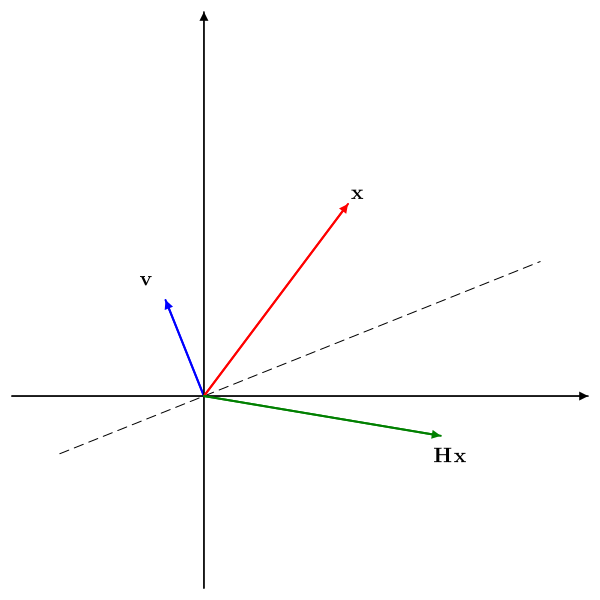

In [6]:
# Householder

function householder_reflection(v::Union{Vector{T}, Matrix{T}}, τ=2.0) where T<:Number
    if x<:Vector
        v = normalize(hcat(x))
    else
        v = copy(x)
    end

    Hv = I - τ * (v1 * v1')
    return Hv
end


τ = 2.0
v = [-0.4; 1.0]
v1 = hcat(v)
vp = hcat([-v[2], v[1]]) # unit perpendicular vector to v1
Hv = I - τ * (v1 * v1')/(norm(v1)^2)
x = hcat([1.5, 2.0])
x2 = Hv*x
plot([0, v[1]], [0, v[2]], frame=:origin, xlim=(-2, 4), ylim=(-2, 4), arrow=(:closed, 2.0), 
    aspect_ratio = :equal, xticks=[], yticks=[],label=nothing, lc=:blue, lw=2, size=(600, 600))
annotate!(v[1]-0.2, v[2]+0.2, L"$\textbf{v}$", :color)
plot!([-2, 4], [0, 0], lc=:black, lw=1 ,label = nothing, arrow=(:closed, 3.0))
plot!([0, 0], [-2, 4], lc=:black, lw=1 ,label = nothing, arrow=(:closed, 2.0))

plot!([-1.5, 3.5], [vp[2]/vp[1]*(-1.5), vp[2]/vp[1]*3.5], lc=:black, lw=1 ,ls=:dash, label = nothing)

plot!([0, x[1]], [0, x[2]],  arrow=(:closed, 2.0), label=nothing, lc=:red, lw=2)
annotate!(x[1]+0.1, x[2]+0.1, L"$\textbf{x}$", :color)

plot!([0, x2[1]], [0, x2[2]],  arrow=(:closed, 2.0), label=nothing, lc=:green, lw=2)
annotate!(x2[1]+0.1, x2[2]-0.2, L"$\textbf{Hx}$", :color)

In [7]:
vp

2×1 Matrix{Float64}:
 -1.0
 -0.4

In [27]:
function qr_householder(A::AbstractMatrix{T}, normeps=1.0e-14) where T<:Number
    M, N = size(A)
    Q = zeros(Float64, (M, N))
    for i = 1:min(M, N)
        Q[i, i] = one(T)
    end
    R = copy(A)

    for i in 1:N
        x = R[i:M, i]
        if T<:Real 
            α = - sign(x[1]) * norm(x)
        else 
            α = -exp(im*atan(im(x[1]), re(x[1]))) * norm(x)
        end

        u = [x[1] - α ; x[2:end] ]
        if norm(u) < normeps continue; end    # skip this iteration
        u = normalize(u);
        println(u)
        # Apply the reflection to each relevant column of A and Q
        for j in 1:N
            R[i:M, j] -= u*( 2*(u'*R[i:M, j]) )
        end
        for j in 1:M
            Q[j, i:M] -= (Q[j, i:M] * u' * u *2)
        end
    end
    
    return Q, triu(R)

end

function qrfact(A)
    m,n = size(A)
    Qt = diagm(ones(m))
    R = float(copy(A))
    for k in 1:n
        z = R[k:m,k]
        w = [ -sign(z[1])*norm(z) - z[1]; -z[2:end] ]
        nrmw = norm(w)
        if nrmw < eps() continue; end    # skip this iteration
        v = w / nrmw;
        println(v)
        # Apply the reflection to each relevant column of A and Q
        for j in 1:n
            R[k:m,j] -= v*( 2*(v'*R[k:m,j]) )
        end
        for j in 1:m
            Qt[k:m,j] -= v*( 2*(v'*Qt[k:m,j]) )
        end
    end
    return Qt',triu(R)
end

qrfact (generic function with 1 method)

In [28]:
# @btime qr_householder(A);
# @btime qrfact(A);

In [29]:
A

4×4 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0  1.0  0.0  -1.0
 1.0  0.0  1.0   2.0
 0.0  1.0  0.0   0.0
 0.0  0.0  1.0   1.0

In [30]:
Q2, R2 = qr_householder(A)

[0.9238795325112867, 0.3826834323650898, 0.0, 0.0]
[-0.8880738339771153, 0.4597008433809831, 0.0]
[0.8660254037844386, 0.4999999999999999]
[-1.0]


([-1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 -0.9999999999999996 0.0; 0.0 0.0 0.0 0.9999999999999996], [-1.414213562373095 -0.7071067811865475 -0.7071067811865476 -0.7071067811865476; 0.0 1.224744871391589 -0.40824829046386313 -1.224744871391589; 0.0 0.0 -1.154700538379251 -1.7320508075688763; 0.0 0.0 0.0 0.9999999999999991])

In [31]:
Q3, R3 = qrfact(A)

[-0.9238795325112866, -0.3826834323650898, -0.0, -0.0]
[0.8880738339771153, -0.4597008433809831, -0.0]
[-0.8660254037844386, -0.4999999999999999]
[1.0]


([-0.707106781186547 0.40824829046386313 0.28867513459481275 -0.4999999999999999; -0.7071067811865475 -0.40824829046386313 -0.28867513459481275 0.4999999999999999; 0.0 0.8164965809277261 -0.28867513459481275 0.49999999999999983; 0.0 0.0 -0.8660254037844384 -0.5000000000000002], [-1.4142135623730945 -0.707106781186547 -0.7071067811865475 -0.7071067811865479; 0.0 1.2247448713915892 -0.40824829046386313 -1.224744871391589; 0.0 0.0 -1.154700538379251 -1.7320508075688763; 0.0 0.0 0.0 0.9999999999999991])

In [101]:
Q3

4×4 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.707107   0.408248   0.288675  -0.5
 -0.707107  -0.408248  -0.288675   0.5
  0.0        0.816497  -0.288675   0.5
  0.0        0.0       -0.866025  -0.5

In [102]:
Q3*R3

4×4 Matrix{Float64}:
 1.0   1.0          -1.67573e-16  -1.0
 1.0  -5.71993e-16   1.0           2.0
 0.0   1.0          -4.4305e-16   -1.16573e-15
 0.0   0.0           1.0           1.0

In [32]:
Q2*R2

4×4 Matrix{Float64}:
 1.41421  0.707107   0.707107   0.707107
 0.0      1.22474   -0.408248  -1.22474
 0.0      0.0        1.1547     1.73205
 0.0      0.0        0.0        1.0

In [33]:
eye(3)

UndefVarError: UndefVarError: eye not defined

In [34]:
eyes(3)

UndefVarError: UndefVarError: eyes not defined